In [1]:
import os
import cv2
import json
import numpy as np
import subprocess
import itertools
import random
from matplotlib import pyplot as plt

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.structures import BoxMode

from d2go.utils.demo_predictor import DemoPredictor
from d2go.runner import GeneralizedRCNNRunner
from d2go.model_zoo import model_zoo

from mobile_cv.predictor.api import create_predictor

setup_logger()

<Logger detectron2 (DEBUG)>

In [4]:
def get_dataset_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in imgs_anns.items():
        if len(v["regions"]['0']['shape_attributes']['all_points_x']) < 20:
          continue
        record = {}
        filename = os.path.join(img_dir, v["filename"])
        width, height = cv2.imread(filename).shape[:2]        
        record["file_name"] = filename
        record["height"] = width 
        record["width"] = height
        record["image_id"] = idx
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = list(itertools.chain.from_iterable(poly))

            obj = {
                "bbox": [np.min(px).tolist(), np.min(py).tolist(), np.max(px).tolist(), np.max(py).tolist()],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        print("Total Lenght: {} name: {}".format(len(dataset_dicts),record["file_name"]), end="/r")
    return dataset_dicts

balloon_metadata = MetadataCatalog.get("balloon_train")

def prepare_for_launch():
    runner = GeneralizedRCNNRunner()
    cfg = runner.get_default_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("mask_rcnn_fbnetv3g_fpn.yaml"))
    cfg.MODEL_EMA.ENABLED = False
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = "output/model_0029999.pth"
    cfg.MODEL.DEVICE = 'cuda'
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.35 # THRESHOLD
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 
    return cfg, runner

cfg, runner = prepare_for_launch()
model = runner.build_model(cfg)
predictor = DemoPredictor(model)

Arguments ['zero_last_bn_gamma', 'width_divisor', 'dw_skip_bnrelu'] skipped for op Conv2d


In [5]:
cfg['MODEL']['DEVICE']

'cuda'

In [6]:
dataset_dicts = DatasetCatalog.get('balloon_train')

KeyError: "Dataset 'balloon_train' is not registered! Available datasets are: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_minival_100, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2014_minival_100, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fine_sem_seg_val, cityscapes_fine_instance_seg_test, cityscapes_fine_sem_seg_test, cityscapes_fine_panoptic_train, cityscapes_fine_panoptic_val, voc_2007_trainval, voc_2007_train, voc_2007_val, voc_2007_test, voc_2012_trainval, voc_2012_train, voc_2012_val, ade20k_sem_seg_train, ade20k_sem_seg_val"

Arguments ['width_divisor', 'zero_last_bn_gamma', 'dw_skip_bnrelu'] skipped for op Conv2d


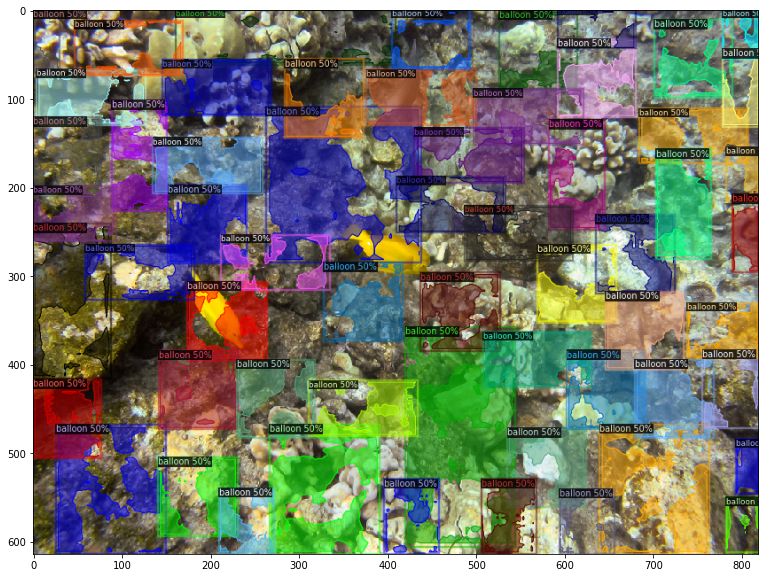

In [94]:
model = runner.build_model(cfg)
predictor = DemoPredictor(model)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

Arguments ['width_divisor', 'zero_last_bn_gamma', 'dw_skip_bnrelu'] skipped for op Conv2d


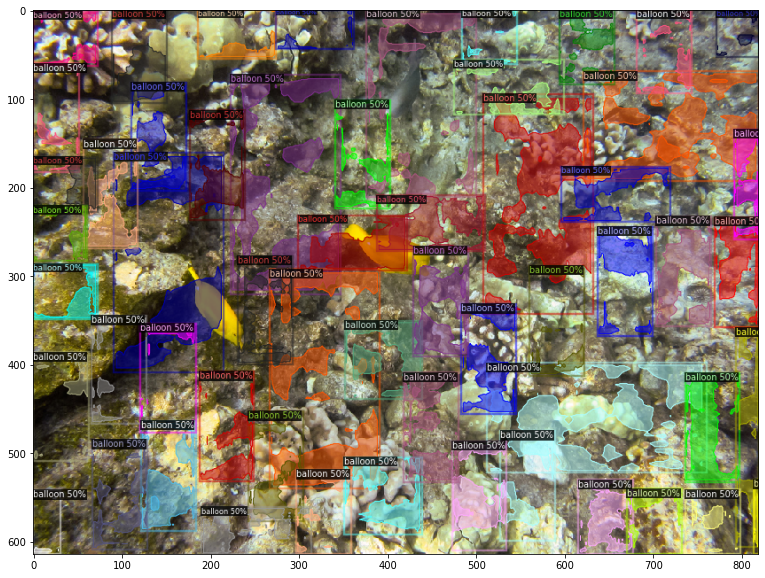

In [96]:
model = runner.build_model(cfg)
predictor = DemoPredictor(model)
im = cv2.imread(d["file_name"])
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

In [74]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")

In [80]:
from mobile_cv.predictor.api import create_predictor
from d2go.utils.demo_predictor import DemoPredictor

model = create_predictor("output/model_0019999.pth")
predictor = DemoPredictor(model)

dataset_dicts = DatasetCatalog.get('balloon_val')
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

NotADirectoryError: [Errno 20] Not a directory: 'output/model_0019999.pth/predictor_info.json'

In [90]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("faster_rcnn_fbnetv3a_C4.yaml"))
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.35 # THRESHOLD
cfg.MODEL.WEIGHTS = "output/model_0019999.pth"
cfg.MODEL.DEVICE='cpu'
model = DefaultPredictor(cfg)

KeyError: 'Non-existent config key: MODEL.FBNET_V2'

In [83]:
dataset_dicts = DatasetCatalog.get('balloon_val')

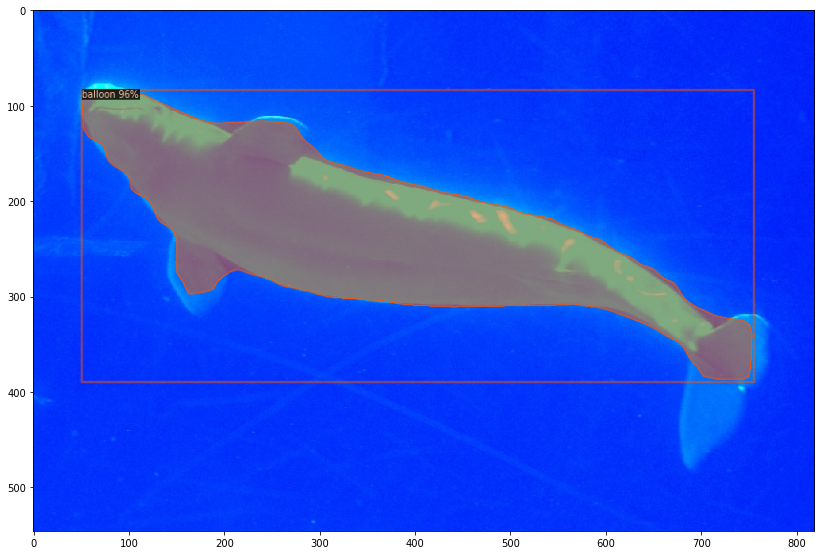

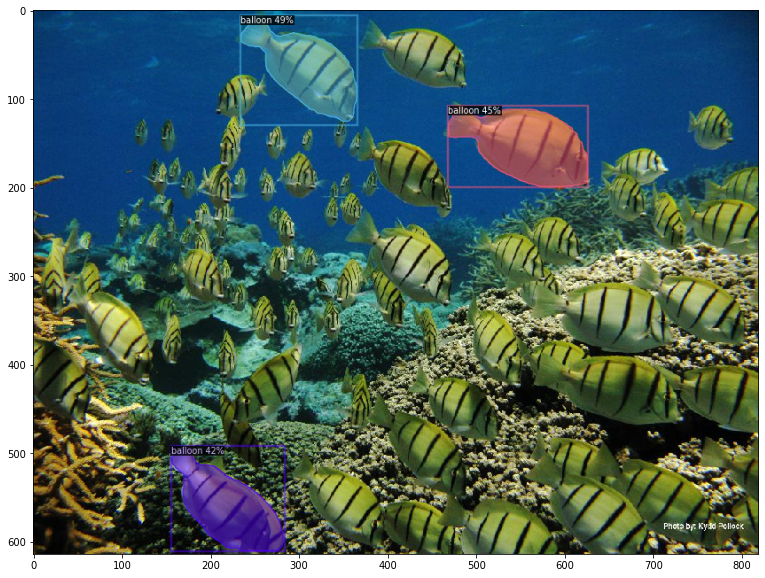

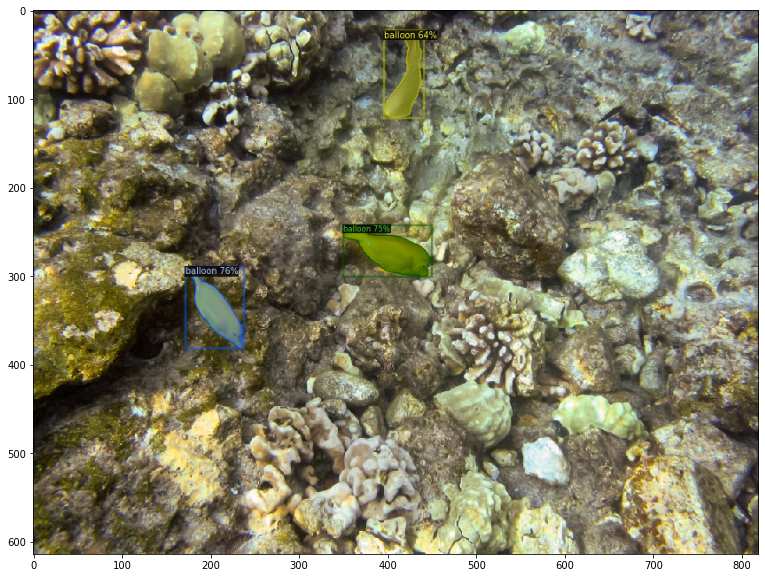

In [88]:
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = model(im)
    v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [8]:
def read_json(path):
    if os.path.isfile(path):
        with open(path) as f:
            data = json.load(f)
        return data
    else:
        return None

In [12]:
import pandas as pd
import os
import json
def get_pd_df(path):
    
    total_dict = {
        'file_name': [],
        'dict': [],
        'step': []
    }

    for i in [x[0] for x in os.walk(path)]:
        eval_result = read_json(os.path.join(i, 'score_of_models.json'))
        config = read_json(os.path.join(i, 'score_of_models.json'))
        if eval_result != None:
            for single_eval in eval_result:
                total_dict['dict'].append(os.path.basename(i))
                total_dict['file_name'].append(single_eval)
                
                for key in eval_result[single_eval]:
                    if key in total_dict:
                        total_dict[key].append(eval_result[single_eval][key])
                    else:
                        total_dict.update({key: [eval_result[single_eval][key]]})
                        
                total_dict['step'].append(int(''.join([x if x.isdigit() else '' for x in single_eval])))
                for key in config:
                    if key in total_dict:
                        total_dict[key].append(config[key])
                    else:
                        total_dict.update({key: [config[key]]})
                        
    df = pd.DataFrame.from_dict(total_dict)
    df['SUM'] = df['AP']  + df['AP50'] + df['AP75'] + \
                df['APs'] + df['APm']  + df['APl']
    sum_c = df['SUM']
    df.drop(labels=['SUM'], axis=1,inplace = True)
    df.insert(0, 'SUM', sum_c)
    return df

In [2]:
folder = "../output/amp_on"
df = get_pd_df(folder)
df.sort_values(by=['SUM'], ascending=False)

FileNotFoundError: [Errno 2] No such file or directory: 'output_aug/score_of_models.json'

In [276]:
df.to_csv('../best_scores/amp_on.csv', index=False) 

In [2]:
df = pd.read_csv('../best_scores/amp_on.csv')

NameError: name 'pd' is not defined

In [3]:
df.sort_values(by=['SUM'], ascending=False)

NameError: name 'df' is not defined

In [11]:
pd.set_option('display.max_rows', 1000)

In [242]:
path = '../fishial_collection/fishial_collection_correct_aug.json'
with open(path) as json_file:
    data = json.load(json_file)
    for p in data:
        print(p)

info
categories
images
annotations
licenses


In [16]:
import weasyprint as wsp
import PIL as pil


def trim(source_filepath, target_filepath=None, background=None):
    if not target_filepath:
        target_filepath = source_filepath
    img = pil.Image.open(source_filepath)
    if background is None:
        background = img.getpixel((0, 0))
    border = pil.Image.new(img.mode, img.size, background)
    diff = pil.ImageChops.difference(img, border)
    bbox = diff.getbbox()
    img = img.crop(bbox) if bbox else img
    img.save(target_filepath)


img_filepath = 'table1.png'
css = wsp.CSS(string='''
@page { size: 2048px 2048px; padding: 0px; margin: 0px; }
table, td, tr, th { border: 1px solid black; }
td, th { padding: 4px 8px; }
''')
html = wsp.HTML(string=df.to_html())
html.write_png(img_filepath, stylesheets=[css])
trim(img_filepath)

AttributeError: 'HTML' object has no attribute 'write_png'

In [13]:
!pip install weasyprint

     |████████████████████████████████| 245kB 3.1MB/s eta 0:00:01
     |████████████████████████████████| 870kB 43.0MB/s eta 0:00:01
     |████████████████████████████████| 112kB 96.9MB/s eta 0:00:01
     |████████████████████████████████| 2.0MB 103.9MB/s eta 0:00:01
     |████████████████████████████████| 358kB 93.0MB/s eta 0:00:01
     |████████████████████████████████| 112kB 104.5MB/s eta 0:00:01
ERROR: bleach 1.5.0 has requirement html5lib!=0.9999,!=0.99999,<0.99999999,>=0.999, but you'll have html5lib 1.1 which is incompatible.
  Found existing installation: html5lib 0.9999999
    Uninstalling html5lib-0.9999999:
      Successfully uninstalled html5lib-0.9999999
